In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"otaviocozer","key":"a0d0b6bb92ca10ebd24e1371edf6d7ab"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d lgmoneda/br-coins

mkdir: cannot create directory ‘/root/.kaggle’: File exists
br-coins.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/br-coins.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: regression_dataset/all/125_1479424848.jpg  
  inflating: regression_dataset/all/130_1477861908.jpg  
  inflating: regression_dataset/all/130_1477861914.jpg  
  inflating: regression_dataset/all/130_1477861920.jpg  
  inflating: regression_dataset/all/130_1477861926.jpg  
  inflating: regression_dataset/all/130_1477861932.jpg  
  inflating: regression_dataset/all/130_1477861938.jpg  
  inflating: regression_dataset/all/130_1477861944.jpg  
  inflating: regression_dataset/all/130_1477861950.jpg  
  inflating: regression_dataset/all/130_1477861956.jpg  
  inflating: regression_dataset/all/130_1477861962.jpg  
  inflating: regression_dataset/all/130_1477861968.jpg  
  inflating: regression_dataset/all/130_1477861974.jpg  
  inflating: regression_dataset/all/130_1477861980.jpg  
  inflating: regression_dataset/all/130_1477861986.jpg  
  inflating: regression_dataset/all/130_1477861992.jpg  
  inflating: regression_datas

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import time
import glob as glob
import os

import cv2 as cv
from google.colab.patches import cv2_imshow

import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

In [ ]:
IMAGES_DIR = 'COCO_labelme_classification/classification'

IMAGE_PATHS = glob.glob(f"{IMAGES_DIR}/*.jpg")
ALL_IMAGES = [image_path.split(os.path.sep)[-1] for image_path in IMAGE_PATHS]

TRAIN_IMAGES, VALIDATION_IMAGES = torch.utils.data.random_split(ALL_IMAGES, [0.8, 0.2])

In [ ]:
CLASS_N = 6
CLASSES = ["__background__", "__coin__"]
COIN_W, COIN_H = 120, 120
IMAGE_W, IMAGE_H = (640 // COIN_W) * COIN_W, (480 // COIN_H) * COIN_H

def sliding_window(img, w, h):
    tiles = []
    boxes = []
    for x in range(0,img.shape[0],h//2):
        for y in range(0,img.shape[1],w//2):
            xi = x
            xf = x + h
            if(xf > img.shape[0]):
                xf = img.shape[0]
                xi = img.shape[0] - h

            yi = y
            yf = y + h
            if(yf > img.shape[1]):
                yf = img.shape[1]
                yi = img.shape[1] - w

            tiles.append(img[xi:xf,yi:yf])
            boxes.append([xi,xf,yi,yf])
    return tiles, boxes


def getitem(dir_name, image_name, width, height):
    image_path = os.path.join(dir_name, image_name)

    image = cv.imread(image_path)
    image_resized = cv.resize(image, (width, height))

    boxes = []
    labels = []

    annot_filename = image_name[:-4] + '.json'
    annot_file_path = os.path.join(dir_name, annot_filename)
    with open(annot_file_path) as my_file:
      annot_boxes = json.loads(my_file.read())

    image_width = image.shape[1]
    image_height = image.shape[0]

    for shape in annot_boxes["shapes"]:
        if shape["label"] == "finger" or shape["shape_type"] == "polygon":
            continue

        xc = int(shape["points"][0][0])
        yc = int(shape["points"][0][1])

        xmin, xmax = xc - COIN_W//2, xc + COIN_W//2
        ymin, ymax = yc - COIN_H//2, yc + COIN_H//2

        labels.append(CLASSES.index("__coin__"))

        xmin_final, xmax_final = int((xmin/image_width)*width), int((xmax/image_width)*width)
        ymin_final, ymax_final = int((ymin/image_height)*height), int((ymax/image_height)*height)

        boxes.append([xmin_final, xmax_final, ymin_final, ymax_final])

    target = {}
    target["boxes"] =  boxes
    target["labels"] = labels

    return image_resized, target


def get_hog() :
    winSize = (COIN_W, COIN_H)
    blockSize = (48, 48)
    blockStride = (24,24)
    cellSize = (48, 48)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradient = True

    return cv.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradient)


def find_intersection(boxes, b):
    for i in range(len(boxes)):
        box = boxes[i]
        xmin = max(box[0], b[0])
        ymin = max(box[2], b[2])

        xmax = min(box[1], b[1])
        ymax = min(box[3], b[3])

        if xmin < xmax and ymin < ymax:
            inter = (xmax - xmin) * (ymax - ymin)
            a1 = (box[1] - box[0]) * (box[3] - box[2])
            a2 = (b[1] - b[0]) * (b[3] - b[2])
            iou = inter / (a1 + a2 - inter)
            # print(iou)
            if iou > 0.8:
                return i

    return -1


print('Defining HoG parameters ...')
# HoG feature descriptor
hog = get_hog();

print('Calculating HoG descriptor for every image ... ')
hog_descriptors_train = []
labels_train = []
negative_hog = []
negative_labels = []
for img_name in TRAIN_IMAGES:
    img, target = getitem(IMAGES_DIR, img_name, IMAGE_W, IMAGE_H)
    if len(target["labels"]) <= 0:
        continue

    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    tiles, boxes = sliding_window(img, COIN_W, COIN_H)
    for tile, box in zip(tiles, boxes):
        xmin, xmax, ymin, ymax = box
        idx = find_intersection(target["boxes"], box)
        if idx != -1:
            label = target["labels"][idx]
            hog_descriptors_train.append(hog.compute(tile))
            labels_train.append(label)
        else:
            negative_hog.append(hog.compute(tile))
            negative_labels.append(CLASSES.index("__background__"))

negative_labels = negative_labels[:len(hog_descriptors_train)]
negative_hog = negative_hog[:len(labels_train)]

print(f"hog_descriptors_train: {len(hog_descriptors_train)}")
print(f"negative_hog: {len(negative_hog)}")
print(f"TRAIN_IMAGES: {len(TRAIN_IMAGES)}")

hog_descriptors_train = np.squeeze(hog_descriptors_train + negative_hog)
labels_train = np.array(labels_train + negative_labels)
print(hog_descriptors_train.shape, labels_train.shape)


Defining HoG parameters ...
Calculating HoG descriptor for every image ... 
hog_descriptors_train: 198
negative_hog: 198
TRAIN_IMAGES: 2445
(396, 144) (396,)


In [ ]:
gamma = 1/len(hog_descriptors_train[0])

def svmInit(C=1, gamma=0.50625):
    model = cv.ml.SVM_create()
    model.setGamma(gamma)
    model.setC(C)
    model.setKernel(cv.ml.SVM_RBF)
    model.setType(cv.ml.SVM_C_SVC)

    return model

print('Training SVM model ...')
model = svmInit(0.5 , gamma)
model.train(hog_descriptors_train, cv.ml.ROW_SAMPLE, labels_train)

Training SVM model ...


True

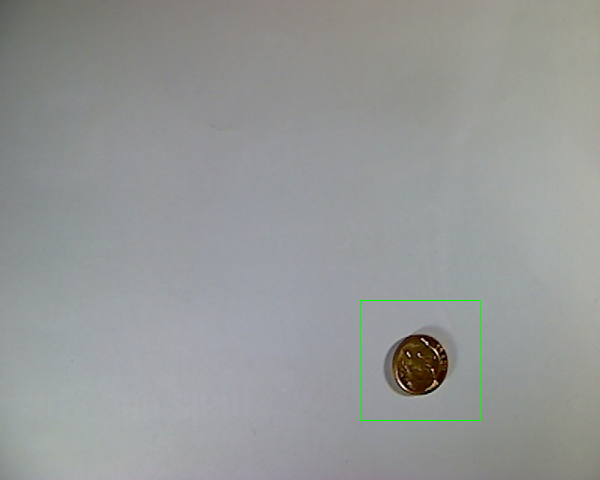

In [ ]:
def non_max_suppression_fast(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    pick = []
    x1 = boxes[:,0]
    x2 = boxes[:,1]
    y1 = boxes[:,2]
    y2 = boxes[:,3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last],np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")

img, target = getitem(IMAGES_DIR, VALIDATION_IMAGES[250], IMAGE_W, IMAGE_H)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
tiles, boxes = sliding_window(gray, COIN_W, COIN_H)

hog_descriptors_predict = [hog.compute(t) for t in tiles]

hog_descriptors_predict = np.squeeze(hog_descriptors_predict)

predicts = model.predict(hog_descriptors_predict)[1].ravel()

bs = []
for t, p, b in zip(tiles, predicts, boxes):
    if CLASSES[int(p)] == "__coin__":
        bs.append(b)

bs = np.array(bs)
bs = non_max_suppression_fast(bs, 0.2)

for xi, xf, yi, yf in bs:
    img = cv.rectangle(img, (yi, xi), (yf, xf), (0, 255, 0))
cv2_imshow(img)

In [ ]:
CLASS_N = 6
CLASSES = ["__background__", "__coin__"]
COIN_W, COIN_H = 120, 120
IMAGE_W, IMAGE_H = (640 // COIN_W) * COIN_W, (480 // COIN_H) * COIN_H

positive_keypoints, positive_descriptors, positive_labels = [], [], []
negative_keypoints, negative_descriptors, negative_labels = [], [], []
bw_images, color_images = [], []
labels = []

sift = cv.SIFT_create()
for img_name in TRAIN_IMAGES:

    img, target = getitem(IMAGES_DIR, img_name, IMAGE_W, IMAGE_H)
    if len(target["labels"]) <= 0:
        continue

    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    kps, ds = sift.detectAndCompute(gray, None)
    positive_labels.append(CLASSES.index("__coin__"))
    positive_keypoints.append(kps)
    positive_descriptors.append(ds)
    bw_images.append(gray)
    color_images.append(img)
    labels.append(img_name.split("_")[0])

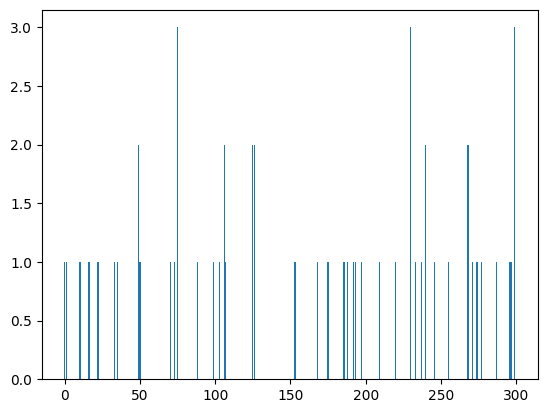

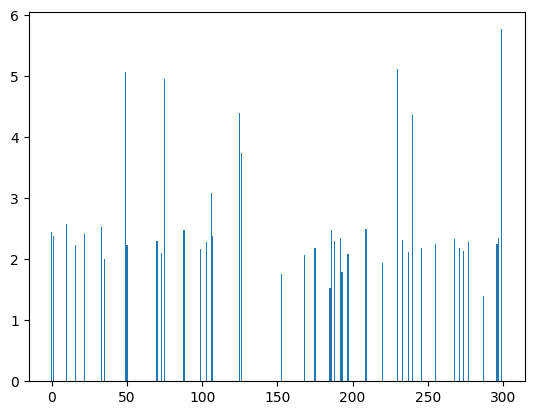

In [ ]:
from scipy.cluster.vq import kmeans
from scipy.cluster.vq import vq


all_descriptors = []
for img_descriptors in positive_descriptors:

    for descriptor in img_descriptors:
        all_descriptors.append(descriptor)

all_descriptors = np.stack(all_descriptors)


k = 300
iters = 10
codebook, variance = kmeans(all_descriptors, k, iters)


visual_words = []
for img_descriptors in positive_descriptors:

    img_visual_words, distance = vq(img_descriptors, codebook)
    visual_words.append(img_visual_words)

frequency_vectors = []
for img_visual_words in visual_words:

    img_frequency_vector = np.zeros(k)
    for word in img_visual_words:
        img_frequency_vector[word] += 1
    frequency_vectors.append(img_frequency_vector)

frequency_vectors = np.stack(frequency_vectors)

plt.bar(list(range(k)), frequency_vectors[0])
plt.show()

N = len(TRAIN_IMAGES)
df = np.sum(frequency_vectors > 0, axis=0)
idf = np.log(N/df)
tfidf = frequency_vectors * idf

plt.bar(list(range(k)), tfidf[0])
plt.show()

25: 1.0 label: 10


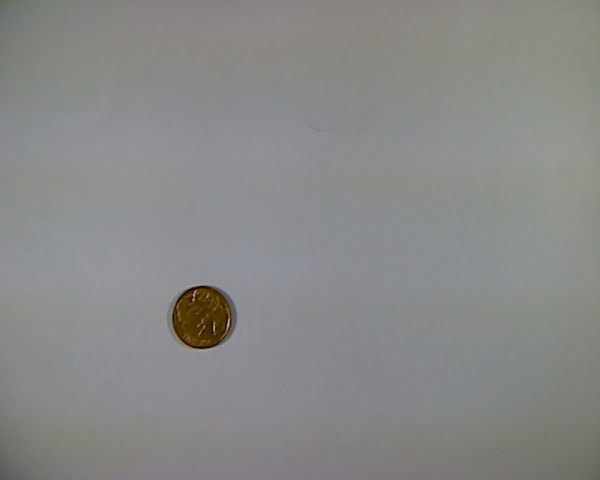

440: 0.5065 label: 10


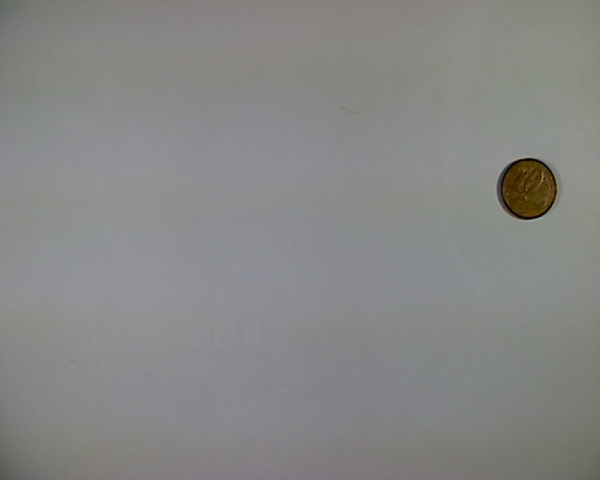

1284: 0.5032 label: 5


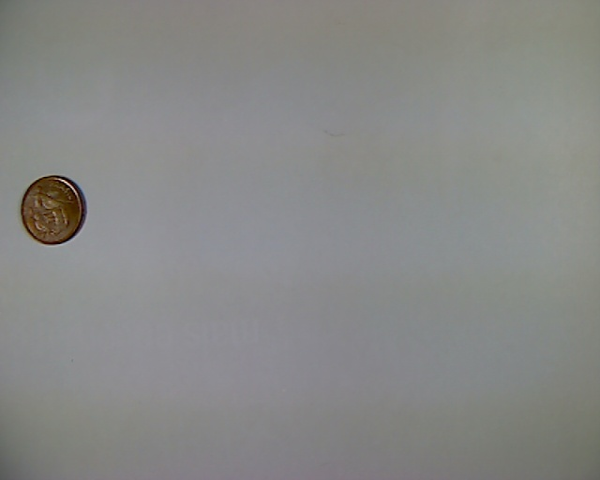

106: 0.4964 label: 5


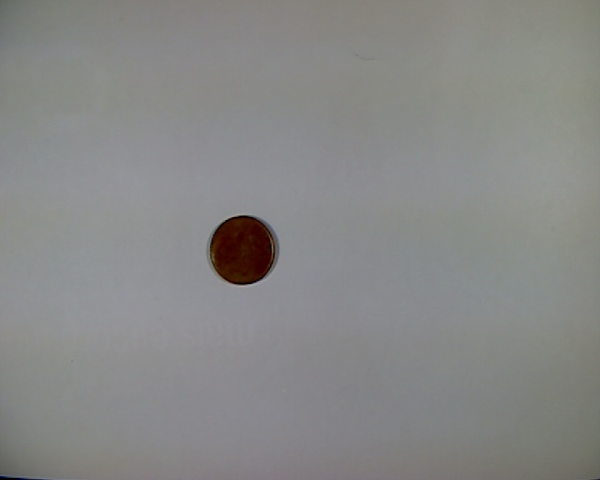

2180: 0.4933 label: 25


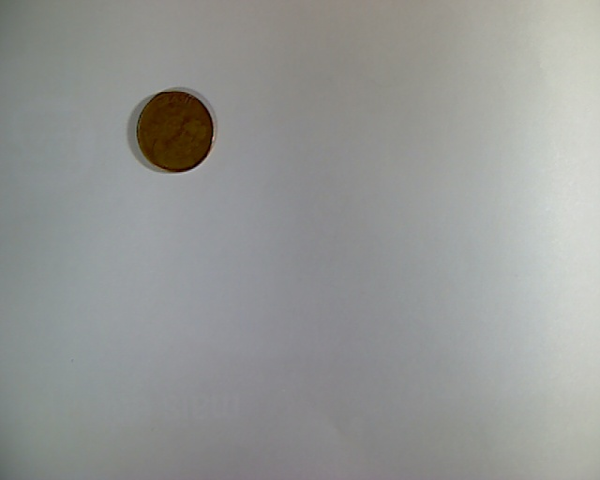

In [ ]:
from numpy.linalg import norm

top_k = 5
i = 25


a = tfidf[i]
b = tfidf

cosine_similarity = np.dot(a, b.T)/(norm(a) * norm(b, axis=1))

idx = np.argsort(-cosine_similarity)[:top_k]

for i in idx:
    print(f"{i}: {round(cosine_similarity[i], 4)} label: {labels[i]}")
    cv2_imshow(color_images[i])

In [ ]:
###################
# OPTICAL FLOW
###################
cap = cv.VideoCapture("/content/video.avi")
points = [287, 139, 40, 44]

lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))


ret, old_frame = cap.read()
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)

sift = cv.SIFT_create()
mask = np.zeros_like(old_gray)
mask[points[1]:points[1]+points[3], points[0]:points[0]+points[2]] = 1
kp = sift.detect(old_gray,mask)
p0 = [[p.pt[0], p.pt[1]] for p in kp]
p0 = np.array(p0, dtype=np.float32)

size = (int(cap.get(3)), int(cap.get(4)))
result = cv.VideoWriter('filename.avi', cv.VideoWriter_fourcc(*'MJPG'),10, size)

while(1):
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break

    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    st = st.reshape(-1)

    if p1 is not None:
        p1 = p1[st==1]

    for p in p1:
        a, b = p.ravel()
        frame = cv.circle(frame, (int(a), int(b)), 5, (0,255,0), -1)

    result.write(frame)

    old_gray = frame_gray.copy()
    p0 = p1.reshape(-1, 1, 2)

No frames grabbed!


In [ ]:
###########
# CAMSHIFT
###########
cap = cv.VideoCapture("/content/video.avi")
points = [287, 139, 40, 44]
track_window = (points)

ret, frame = cap.read()

roi = frame[points[1]:points[1]+points[3], points[0]:points[0]+points[2]]
hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
mask = cv.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)

# Setup the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

size = (int(cap.get(3)), int(cap.get(4)))
result = cv.VideoWriter('filename2.avi', cv.VideoWriter_fourcc(*'MJPG'),10, size)

while(1):
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break

    if ret == True:
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        # apply camshift to get the new location
        ret, track_window = cv.CamShift(dst, track_window, term_crit)

        # Draw it on image
        pts = cv.boxPoints(ret)
        pts = np.int0(pts)
        img2 = cv.polylines(frame,[pts],True, 255,2)

        result.write(img2)

No frames grabbed!
